In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp -r "/content/drive/My Drive/deep_learning_projects/intrusion_detection/validqueries.txt" ./validqueries.txt
!cp -r "/content/drive/My Drive/deep_learning_projects/intrusion_detection/badqueries.txt" ./badqueries.txt
!ls

badqueries.txt	drive  sample_data  validqueries.txt


## Import Libraries

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import urllib.parse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import random

## Load the datasets

In [0]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath,'r') as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))   #converting url encoded data to simple string
        result.append(d)
    return result

In [0]:
badQueries = loadFile('badqueries.txt')
validQueries = loadFile('validqueries.txt')

### Print Random Valid and Bad Queries

In [6]:
print(random.choices(validQueries, k=5))

['/marketbar2/\n', '/shining force exa_information/\n', '/wts-charter/\n', '/10000001303/\n', '/125471/\n']


In [7]:
print(random.choices(badQueries, k=5))

['/help.php?q=rm;q46895114&rem;\n', '/javascript/cgi-home.exe\n', "/module/forum/forum.php?fd=http://192.168.202.118:8080/tzhfyzkbomspvm?=';\n", '<BR SIZE="&{confirm(\'XSS\')}">\n', '%27\n str=$(echo GBQYNR)\n str1=${#str}\n if [ 1 -ne ${str1} ]\n then sleep 0\n else sleep 1\n fi |\n']


## Data Preprocessing

In [0]:
badQueries = list(set(badQueries))
validQueries = list(set(validQueries))
allQueries = badQueries + validQueries

### set ylabels as 1 for malicious and 0 for valid

In [0]:
yBad = [1 for i in range(0, len(badQueries))]
yGood = [0 for i in range(0, len(validQueries))]

In [0]:
y = yBad + yGood
queries = allQueries

### Vectorization

In [0]:
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3))
X = vectorizer.fit_transform(queries)

### Split Data into Train and Test Set

###### Train:Test Split: 80:20

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
print("Number of samples in Training Set =", X_train.shape[0])
print("Number of samples in Test Set =", X_test.shape[0])

Number of samples in Training Set = 1048404
Number of samples in Test Set = 262102


In [0]:
badCount = len(badQueries)
validCount = len(validQueries)

In [15]:
print("Total Number of valid queries =", validCount)
print("Total Number of bad queries =", badCount)

Total Number of valid queries = 1265974
Total Number of bad queries = 44532


### Logistic Regression

In [0]:
regressor = LogisticRegression(class_weight={1: 2 * validCount / badCount, 0: 1.0}, max_iter=1000)

### Train the model

In [17]:
regressor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 56.856822060540736},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=1000, multi_class='auto',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

## Evaluation

In [0]:
y_pred = regressor.predict(X_test)

In [0]:
fpr, tpr, _ = metrics.roc_curve(y_test, (regressor.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)

In [20]:
print("Bad samples: %d" % badCount)
print("Good samples: %d" % validCount)
print("Baseline Constant negative: %.6f" % (validCount / (validCount + badCount)))
print("------------")
print("Accuracy: %f" % regressor.score(X_test, y_test))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(y_test, y_pred))
print("Recall: %f" % metrics.recall_score(y_test, y_pred))
print("F1-Score: %f" % metrics.f1_score(y_test, y_pred))
print("AUC: %f" % auc)


Bad samples: 44532
Good samples: 1265974
Baseline Constant negative: 0.966019
------------
Accuracy: 0.999401
Precision: 0.985735
Recall: 0.996869
F1-Score: 0.991271
AUC: 0.999934


In [21]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253160
           1       0.99      1.00      0.99      8942

    accuracy                           1.00    262102
   macro avg       0.99      1.00      1.00    262102
weighted avg       1.00      1.00      1.00    262102



## Confusion Matrix

In [22]:
print(metrics.confusion_matrix(y_test, y_pred))

[[253031    129]
 [    28   8914]]


### Plot the Confusion Matrix

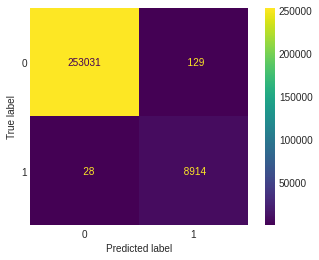

In [23]:
plt.style.use('seaborn-dark')
confusion_matrix = metrics.plot_confusion_matrix(regressor, X_test, y_test, values_format='5d')
plt.show()

## Save the model

In [0]:
import pickle

filename = 'ids_model.pkl'
pickle.dump(regressor, open(filename, 'wb'))

### Load the model

In [25]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)


0.9994009965585917
